Non-Vehicles 16530 ./training_data/non-vehicles/sven/nocar_6815.png
Vehicles 11220 ./training_data/vehicles/GTI_Far/image0446.png
Reading...
Done!
Reading...
Done!
Features: Cars 22440 No car 22440
Labels: Cars 22440 No car 22440


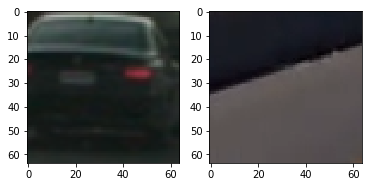

In [3]:
import keras
import numpy as np
import os
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from glob import glob
import pandas
import matplotlib.pyplot as plt
import cv2
import random 




def read_images(files):
    print ("Reading...",)
    images = [mpimg.imread(f) for f in files]
    print ("Done!")
    return images
    
    
def augment(images):
    '''simple data augmentation: mirror images vertically'''
    images_augmented = [cv2.flip(img,1) for img in images]
    

    return images_augmented
    
    
    
    

# 0 : non-vehicle, 1 : vehicle
LABELS = [0,1]   

T_DATA_DIR = "./training_data/"

# collect file names for the vehicles / non-vehicles data sets
non_vehicles_fn = glob(T_DATA_DIR + "non-vehicles/extras/*.png")
#non_vehicles_fn += glob(T_DATA_DIR + "non-vehicles/GTI/*.png")
non_vehicles_fn += glob(T_DATA_DIR + "non-vehicles/sven/*.png")
# TODO: add some more non-vehicle images from crowdai (?) to balance data set as the project dataset contains only 3900 images
# for now just duplicate 
#non_vehicles_fn += get_crowdai_non_vehicle(T_DATA_DIR + "object-detection-crowdai")

non_vehicles_fn += non_vehicles_fn

# add vehicle images from project datasets, 8792 images
vehicles_fn = glob(T_DATA_DIR + "vehicles/GTI_Far/*.png")
vehicles_fn += glob(T_DATA_DIR + "vehicles/GTI_Left/*.png")
vehicles_fn += glob(T_DATA_DIR + "vehicles/GTI_MiddleClose/*.png")
vehicles_fn += glob(T_DATA_DIR + "vehicles/GTI_Right/*.png")
vehicles_fn += glob(T_DATA_DIR + "vehicles/KITTI_extracted/*.png")
vehicles_fn += glob(T_DATA_DIR + "vehicles/sven/*.png")


print ("Non-Vehicles",len(non_vehicles_fn), non_vehicles_fn[0])
print ("Vehicles", len(vehicles_fn), vehicles_fn[0])







images_car = read_images(vehicles_fn)
images_car += augment(images_car)


# ensure balanced dataset by randomly sampling only as many non-vehicle files as vehicle files
non_vehicles_fn = random.sample(non_vehicles_fn, len(vehicles_fn))

images_non_car = read_images(non_vehicles_fn)
images_non_car += augment(images_non_car)



# one-hot encoding
labels_non_car = [[1,0] for i in range(len(images_non_car))]


# one-hot encoding
labels_car = [[0,1] for i in range(len(images_car))]

print ("Features: Cars", len(images_car), "No car", len(images_non_car))
print ("Labels: Cars", len(labels_car), "No car", len(labels_non_car))




plt.subplot(121)
plt.imshow(images_car[100])
plt.subplot(122)
plt.imshow(images_non_car[500])
plt.show()




In [4]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Input, Dropout
from keras import optimizers

from keras.applications import VGG16, VGG19
import keras.backend

from keras.backend import tf as ktf



import h5py

EPOCHS = 14
BATCH_SIZE = 512


def vgg16_classifier(device='/gpu:1'):
    print ("Using Device:",device)
    #base_model = VGG16(include_top = False, weights='imagenet', input_shape=(84,320,3))
    with ktf.device(device):
        # perform normalization at beginning of base VGG16 model
        inp = Input(shape=(None, None, 3))
        
        def rescale_f(image):
            import tensorflow as tf
            return tf.image.resize_images(image, (64,64))
        
        # scale images to 64,64 (the base size of the training data of the model)
        sc = Lambda(rescale_f)(inp)
        
        #norm = Lambda(lambda x: (x / 255.0) - 0.5 )(inp)
        base_model = VGG16(include_top = False, weights="imagenet", input_tensor=sc)

        # disable layer training 
        for layer in base_model.layers:
            #pass
            #print (layer.name)
            layer.trainable = False

        # Flatten incoming data to feed to FC layers
        x = Flatten()(base_model.output)
    
        # add some FC layers with dropout to learn from the features detected by VGG 16
        #x = Dense(2048, activation="relu")(x)
        #x = Dropout(0.1)(x)
        #x = Dense(1024, activation="relu")(x)
        #x = Dropout(0.1)(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.1)(x)
        prediction = Dense(2, activation="sigmoid")(x)

        head_model = Model(input = base_model.input, output = prediction )

        opt = optimizers.Nadam(lr=0.00001)

        head_model.compile(loss='categorical_crossentropy', optimizer= opt, metrics =['accuracy'])

        head_model.summary()

        return head_model


X = np.array(images_car + images_non_car)
y = np.array(labels_car + labels_non_car)

print (len(X), len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

print(X_train.shape, y_train.shape)

## train the model

model = vgg16_classifier()

print ("==== Fitting Model ====")
for e in range(EPOCHS):
    model.fit(X_train, y_train, epochs = 2, batch_size = BATCH_SIZE)
    res = model.evaluate(X_test, y_test)
    print ("Evaluate results", res)

model.save('vgg_16_256_64.h5')


44880 44880
(33660, 64, 64, 3) (33660, 2)
Using Device: /gpu:1


/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

33660/33660 [==============================] - 14s 413us/step - loss: 0.0331 - acc: 0.9904
Epoch 2/2
11220/11220 [==============================] - 7s 649us/step
Evaluate results [0.027054111217273111, 0.99144385024613024]


In [5]:
import cv2

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Malisiewicz et al.
# From: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes_in, overlapThresh):
    
    
    
  # if there are no boxes, return an empty list
  if len(boxes_in) == 0:
    return []
  boxes = np.array([(b[0][0], b[0][1], b[1][0], b[1][1]) for b in boxes_in])
 


    
  # if the bounding boxes integers, convert them to floats --
  # this is important since we'll be doing a bunch of divisions
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
 
  # initialize the list of picked indexes  
  pick = []
 
  # grab the coordinates of the bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
 
  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
 
  # keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
 
    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
 
    # compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]
 
    # delete all indexes from the index list that have
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
 
  # return only the bounding boxes that were picked using the
  # integer data type

  out_boxes = []
  for i in pick:
    out_boxes.append(boxes_in[i])
  return out_boxes




In [6]:
import matplotlib.pyplot as plt
import keras
import h5py 
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import tf as ktf

import sys

MODELS_DIR ="./"
LOAD_MODEL = True
if LOAD_MODEL :
    model = load_model(MODELS_DIR + 'vgg_16_256_64.h5')

TEST_IMG_DIR = "test_images/"

test_images = ['test1.jpg',
              'test2.jpg',
              'test3.jpg',
               'test4.jpg',
               'test5.jpg',
               'test6.jpg']

(720, 1280, 3)
50 384 217 24


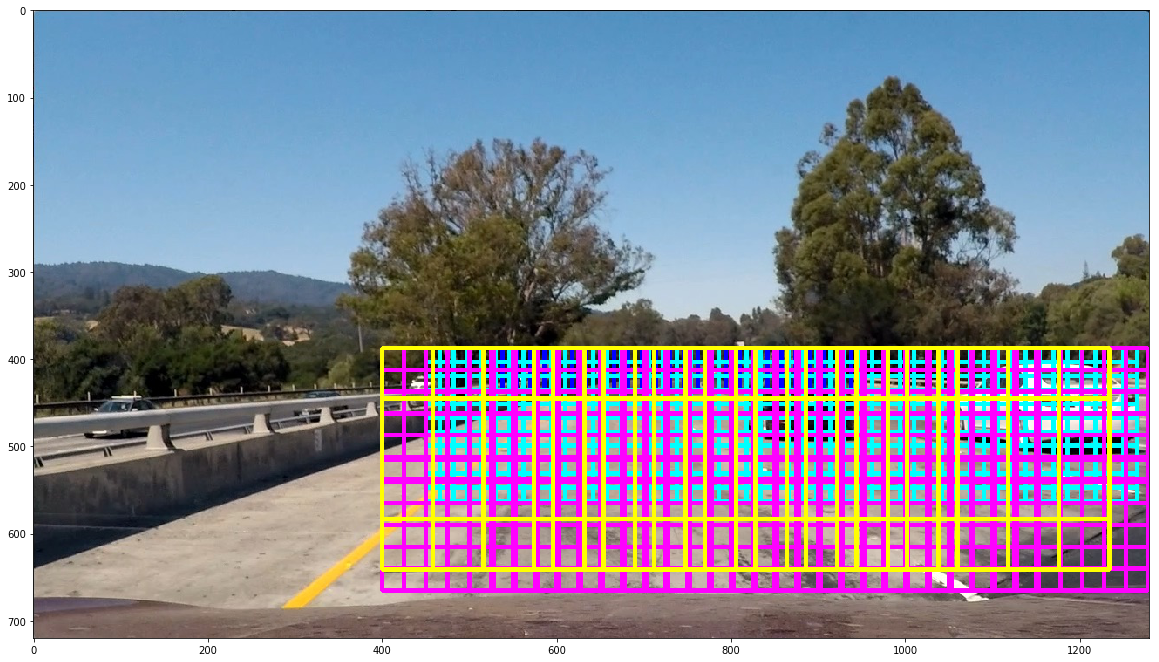

(720, 1280) uint8
3
[[     0      0   1280    720 885715]
 [   775    387    203    153  21473]
 [  1042    403    176    112  14412]]
Found 2 cars
[[(775, 387), (978, 540)], [(1042, 403), (1218, 515)]]


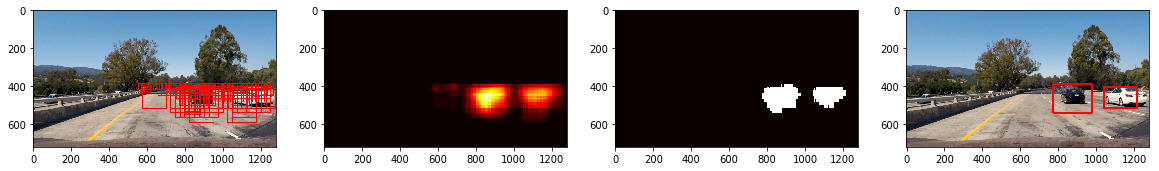

(720, 1280, 3)
50 384 217 24


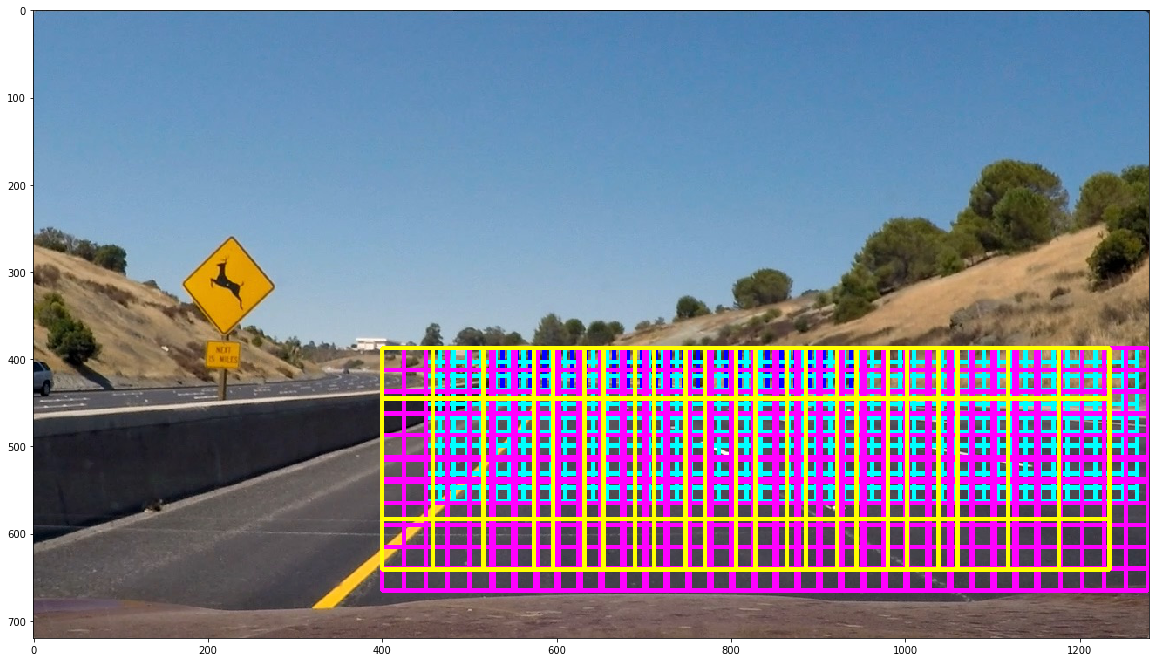

(720, 1280) uint8
1
[[     0      0   1280    720 921600]]
Found 0 cars
[]


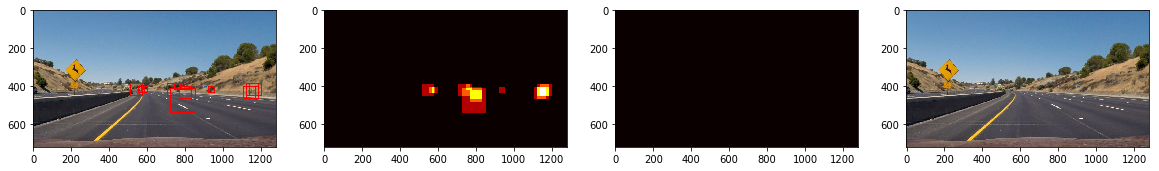

(720, 1280, 3)
50 384 217 24


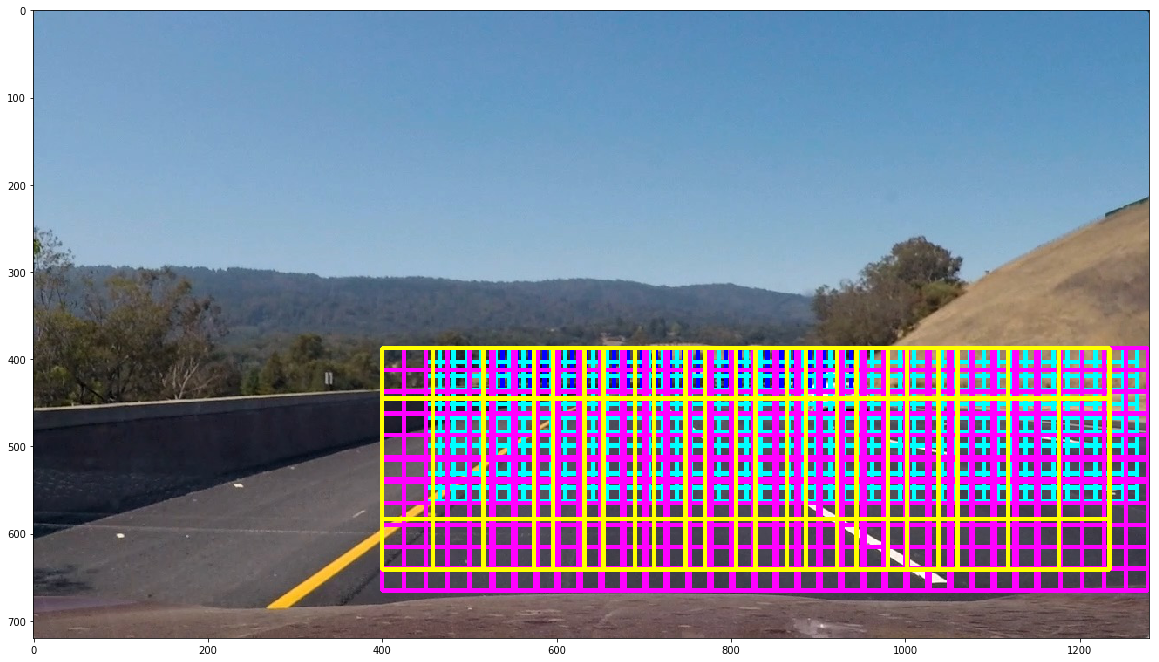

(720, 1280) uint8
2
[[     0      0   1280    720 909266]
 [   786    403    217     96  12334]]
Found 1 cars
[[(786, 403), (1003, 499)]]


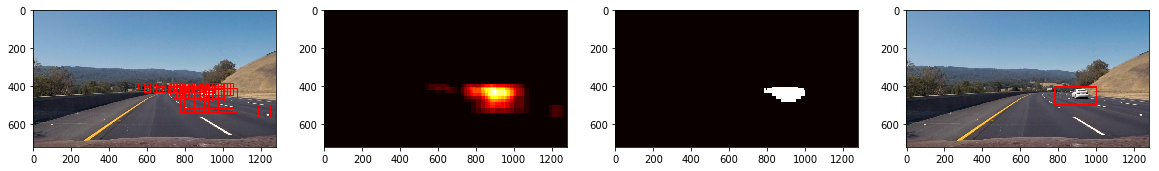

(720, 1280, 3)
50 384 217 24


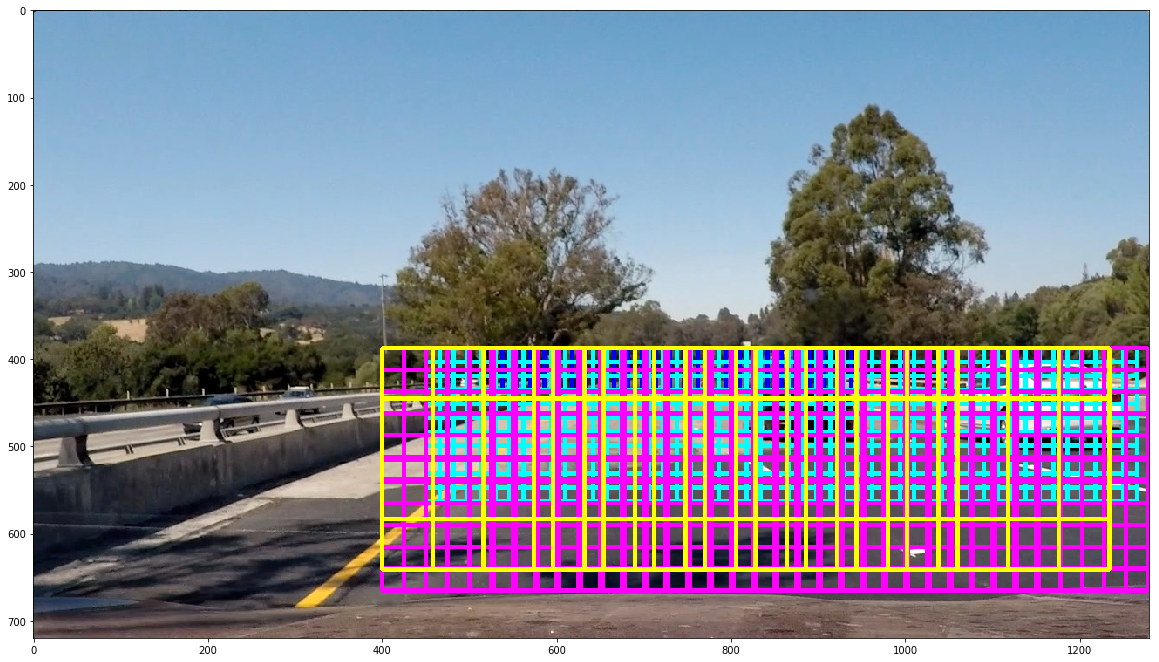

(720, 1280) uint8
6
[[     0      0   1280    720 888512]
 [   770    387    192    153  18890]
 [  1025    403    209    112  14171]
 [   975    512      3      3      9]
 [  1025    512      3      3      9]
 [  1050    512      3      3      9]]
Found 2 cars
[[(770, 387), (962, 540)], [(1025, 403), (1234, 515)]]


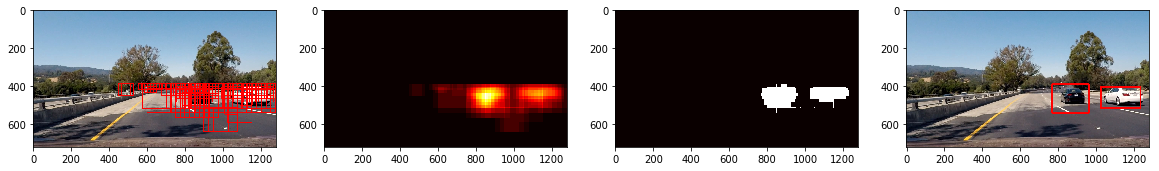

(720, 1280, 3)
50 384 217 24


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


(720, 1280) uint8
3
[[     0      0   1280    720 881097]
 [   775    387    228    153  22800]
 [  1010    403    224    112  17703]]
Found 2 cars
[[(775, 387), (1003, 540)], [(1010, 403), (1234, 515)]]


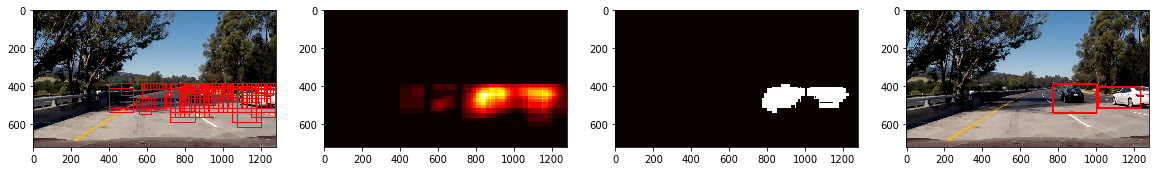

(720, 1280, 3)
50 384 217 24


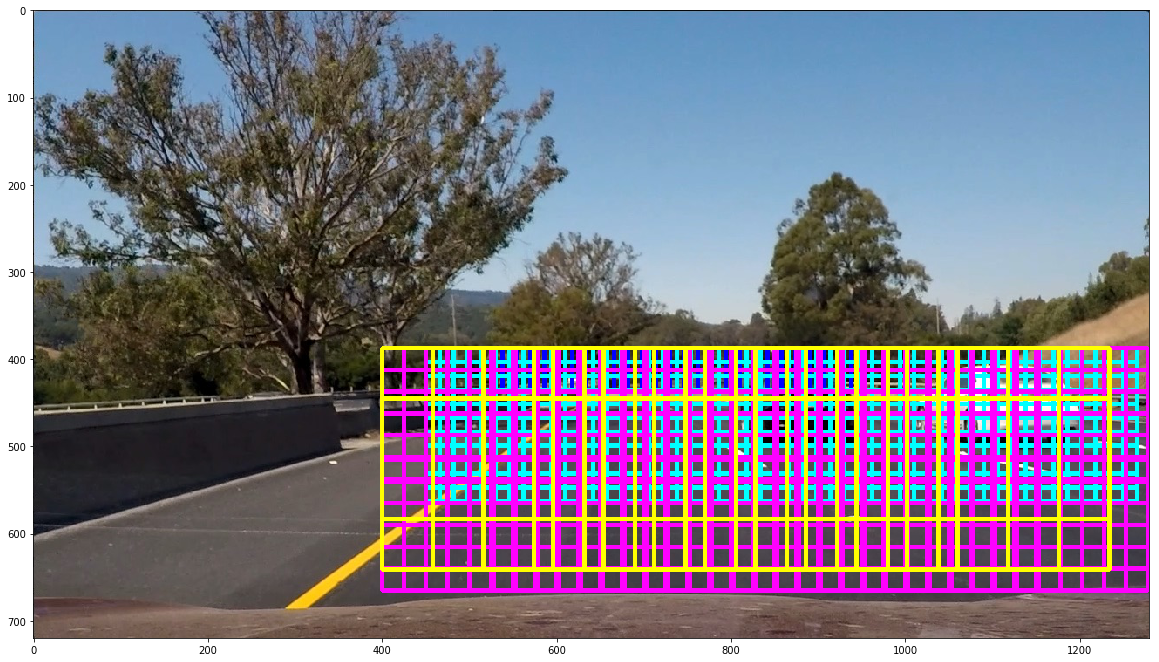

(720, 1280) uint8
2
[[     0      0   1280    720 881397]
 [   754    387    432    128  40203]]
Found 1 cars
[[(754, 387), (1186, 515)]]


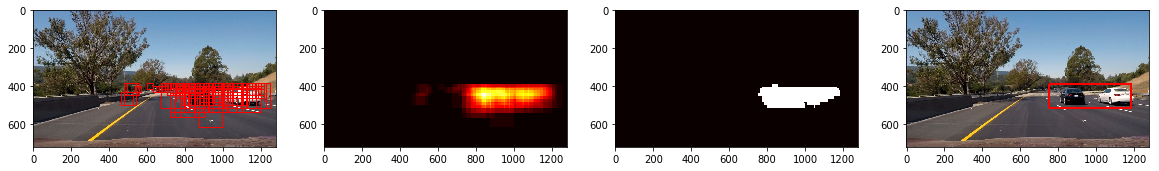

In [15]:


for img_fn in test_images:
    M = cv2.imread(TEST_IMG_DIR+img_fn)
    print (M.shape)
    M = cv2.cvtColor(M, cv2.COLOR_BGR2RGB)
    #plt.imshow(M)
    #plt.show()
    
    windows_small = slide_window(M, x_start_stop=(538, 968), y_start_stop=(387, 437), 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    
    windows_med = slide_window(M, x_start_stop=(450, 1280), y_start_stop=(387, 575), 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    windows_lg = slide_window(M, x_start_stop=(400, 1280), y_start_stop=(387, 677), 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))
    
    windows_xlg = slide_window(M, x_start_stop=(400, 1280), y_start_stop=(387, 677), 
                    xy_window=(196, 196), xy_overlap=(0.7, 0.7))
    
    
    
    all_windows = windows_small + windows_med + windows_lg + windows_xlg
    
    print (len(windows_small), len(windows_med), len(windows_lg), len(windows_xlg))
  
    
    
    
    #print ("Nr. of windows", len(windows_small), len(windows_med), len(windows_lg), len(all_windows))
                       
    window_img = draw_boxes(M, windows_small, color=(0, 0, 255), thick=4)   
    window_img = draw_boxes(window_img, windows_med, color=(0, 255, 255), thick=4)
    window_img = draw_boxes(window_img, windows_lg, color=(255, 0, 255), thick=4)
    window_img = draw_boxes(window_img, windows_xlg, color=(255, 255, 0), thick=4)
    plt.rcParams['figure.figsize'] = (20,20)
    plt.imshow(window_img)
    plt.show()
    
    
    
    crops = []
    
    # TODO: make list comprehension (dowa nor work for some reason)
   
    crops_small = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_small])
    crops_med = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_med])
    crops_lg = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_lg])
    crops_xlg = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_xlg])
    
    
    
    res_small = list(model.predict(crops_small))
    res_med = list(model.predict(crops_med))
    res_lg = list(model.predict(crops_lg))
    res_xlg = list(model.predict(crops_xlg))
    
    res = res_small + res_med + res_lg
    
    
    
    
    window_img = np.array(M)
    
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)

    
    #print (res)
    boxes = []
    for w, r in zip(all_windows, res):
        if r[1] > 0.99:
            #print (w)
            boxes.append(w)
            
    window_img = draw_boxes(window_img, boxes, color=(255,0,0), thick = 3)  
    heat = add_heat(heat, boxes)
     
    thresh = np.array(heat)
    
    thresh = apply_threshold(thresh, 10)
    
   

    ret, thresh = cv2.threshold(thresh, 0,255, cv2.THRESH_BINARY)
    
    
    thresh[thresh > 0] = 1
    thresh = np.uint8(thresh)
    print (thresh.shape, thresh.dtype)
        
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
    
    print (n)
    #print(labels)
    print (stats)
    
    car_boxes = []
    
    n_cars = 0
    for x0,y0,w,h,a in stats[1:]:
        if a > 1750:
            car_boxes.append([(x0,y0),(x0+w,y0+h)])
            n_cars +=1
    print ("Found", n_cars, "cars")
    
    print (car_boxes)
            
    
    car_boxes_img = np.array(M)
    if n_cars >0:
        car_boxes_img = draw_boxes(car_boxes_img, 
                               car_boxes, 
                               color=(255,0,0), 
                               thick=8)
    
    
    plt.rcParams['figure.figsize'] = (20,20)
    plt.subplot(141)
    plt.imshow(window_img)
    plt.subplot(142)
    plt.imshow(heat, cmap='hot')
    plt.subplot(143)
    plt.imshow(thresh, cmap = 'hot')
    plt.subplot(144)
    plt.imshow(car_boxes_img)
    plt.show()
    
            
            
            
    
    
    #for w in windows:
    #    print (w)
    #for c in crops:
    #    plt.imshow(c)
    #    plt.show()
    
    
    